# Intro



Baseball stats from http://www.seanlahman.com/baseball-archive/statistics/
The downloaded data contains complete batting and pitching statistics from 1871 to 2016, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. 

### Note on the performance stats

Data from both regular & post-seasons will be used. So we'll need to merge some tables.

We'll be using following stats to determine a "better" player:
- pitchers: lowest Fielding-independent Pitching (FIP; we'll need to calculate this)
- batters: highest on base + slugging percentage (we'll need to calculate this)
- defense: highest fielding percentage (we'll need to calculate this)


Note that this is a simplistic way at looking at player performance. There are more advanced stats that can be calculated (eg, Sabermetrics), and evaluation of player performance should be based on a few different metrics, not just one. Refer to the links below for more info.

**Evaluating hitters**: https://www.beyondtheboxscore.com/2014/5/26/5743956/sabermetrics-stats-offense-learn-sabermetrics

**Evaluating pitchers**: https://www.beyondtheboxscore.com/2014/6/2/5758898/sabermetrics-stats-pitching-stats-learn-sabermetrics

**Evaluating defense**: https://www.cbssports.com/mlb/news/an-idiots-guide-to-using-defensive-baseball-statistics-to-your-advantage/

## Questions I Want to Ask

- how was the trend of salaries over the years? 
    - overall trend
    - broken down over positions
- what position players earn the most? (pitchers? very good batters?)
- which player earned the most over the course of his career?
- how does batting performance batting average affect salary? 
- how does ERA affect pitcher salary?


### Extra Questions (will explore if I have the time)
- what age players tend to perform the best?
    - pitchers
    - batters
    - fielders/catchers
- are cleanup (4th) batters really better at batting?
- do cleanup batters get walked more than other players?
- how does the offense stats of different # batters compare? Is it really building up to 4th batter, and then decrease near the end of the order? (ie, 8th & 9th batters not as good as 3rd & 4th.)
- how much better are designated hitters (DH) compared to other batters?
- how often do players play multiple positions? Do they get better salary over other players?
- who're the top 3 players for each position? Based on offense + defense
    - pitcher
    - batter
    - fielder
    - catcher
    
- which pitcher/catcher combo performed the best?
    - how was the pitcher performance with other catchers? (aka, does the catcher matter?)
    
- which team won the most games, %-wise? Which team lost the most?
- what's the typical percentage of left hitters/switch hitters in a team? What about left-handed pitchers?
    



# Analysis

## Salaries

Let's start by taking a peek at the salary table.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
salary_df = pd.read_csv('baseballdatabank-2017.1/core/Salaries.csv')
salary_df.head(5)

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


What's the range of years in the table?

In [41]:
print("The salary data is from years", salary_df['yearID'].min(), " to ", salary_df['yearID'].max())

The salary data is from years 1985  to  2016


What's the range of salaries?

In [4]:
print("Min salary is", salary_df['salary'].min(), "; Max salary is", salary_df['salary'].max(),
     "; Mean salary is", salary_df['salary'].mean())

Min salary is 0 ; Max salary is 33000000 ; Mean salary is 2085634.053125473


That's a lot of digits. Let's make it easier to read by converting to million dollars.

In [5]:
salary_df['salary (million)'] = salary_df['salary']/1000000

Min salary = 0 is a bit weird, let's see if it's valid data.

In [6]:
salary_df.loc[salary_df['salary (million)'].idxmin()]

yearID                   1993
teamID                    NYA
lgID                       AL
playerID            jamesdi01
salary                      0
salary (million)            0
Name: 6179, dtype: object

In [7]:
salary_df.loc[salary_df['playerID'] == 'jamesdi01']

,yearID,teamID,lgID,playerID,salary,salary (million)
1302,1987,ATL,NL,jamesdi01,120000,0.1200
1929,1988,ATL,NL,jamesdi01,360000,0.3600
2591,1989,ATL,NL,jamesdi01,400000,0.4000
3536,1990,CLE,AL,jamesdi01,650000,0.6500
5293,1992,NYA,AL,jamesdi01,387500,0.3875
6179,1993,NYA,AL,jamesdi01,0,0.0000
8019,1995,NYA,AL,jamesdi01,350000,0.3500


The data for the player looks valid enough. We might be able to find out the story behind why he didn't get any pay in 1993, but first we need his full name.
Let's load the csv with player info and check that it's loaded correctly.

In [8]:
player_df = pd.read_csv('baseballdatabank-2017.1/core/Master.csv')
player_df.sample(2)

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
14246,reichda01,1976.0,7.0,12.0,USA,CA,Monterey,NaN,NaN,NaN,...,Reichert,Daniel Robert,175.0,75.0,R,R,1999-07-16,2003-09-25,reicd001,reichda01
496,asuajca01,1991.0,11.0,2.0,Venezuela,Lara,Barquisimeto,NaN,NaN,NaN,...,Asuaje,Carlos A.,160.0,69.0,L,R,2016-09-21,2016-10-01,asuac001,asuajca01


In [9]:
player_df.columns

Index(['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame',
       'retroID', 'bbrefID'],
      dtype='object')

In [10]:
def get_player_name (ID):
    last_name = player_df.loc[(player_df['playerID'] == ID), 'nameLast'].values[0]
    first_name = player_df.loc[(player_df['playerID'] == ID), 'nameFirst'].values[0]
    try:
        full_name = first_name + " " + last_name
    except TypeError:
        print('TypeError encountered. ID is', ID, ' , first name is ', first_name, ' last name is ', last_name)
        full_name = 'N/A'
    return full_name

In [11]:
get_player_name('jamesdi01')

'Dion James'

So the player is Dion James. A bit of searching confirms that his salary is indeed $0 in 1993. So we have high confidence to leave the value in our data as it does not appear to be an error.

https://www.baseball-reference.com/players/j/jamesdi01.shtml#all_batting_value

### Salary Trends

Let's look at the trend of average, median and highest salaries over the years.

In [12]:
salary_mean = salary_df.groupby(by='yearID')['salary (million)'].mean()
salary_median = salary_df.groupby(by='yearID')['salary (million)'].median()
salary_max = salary_df.groupby(by='yearID')['salary (million)'].max()
salary_min = salary_df.groupby(by='yearID')['salary (million)'].min()

#convert years to int instead of string
salary_mean.index = salary_mean.index.map(int)
salary_median.index = salary_median.index.map(int)
salary_max.index = salary_max.index.map(int)
salary_min.index = salary_min.index.map(int)

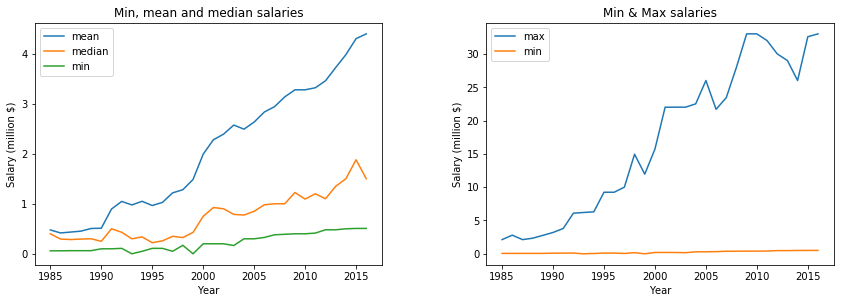

In [13]:
fig = plt.figure()

#plot the median and mean salary
plt.subplot(121)
plt.plot(salary_mean, label='mean')
plt.plot(salary_median, label='median')
plt.plot(salary_min, label='min')
plt.legend()
plt.title('Min, mean and median salaries')
plt.xlabel('Year')
plt.ylabel('Salary (million $)')

#plot the max salary
plt.subplot(122)
plt.plot(salary_max, label='max')
plt.plot(salary_min, label='min')
plt.legend()
plt.title('Min & Max salaries')
plt.xlabel('Year')
plt.ylabel('Salary (million $)')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.95, hspace=0.25,
                    wspace=0.3)

In [38]:
(salary_max/salary_mean).mean()

7.762986175778534

We can see that the salaries have increased over the years, as expected (due to inflation etc). 
However, it's interesting to note that the minimum salary has not been increasing at the same rate as the median and mean salaries, and actually looks flat next to the max salaries. This indicates that the salaries for the highest-paid players have been increasing more rapidly than the rest. This could also be the reason the mean is pulled much higher than the median salaries.

Also, the max salaries seem to be more than 7x the mean salaries - it really pays to be top players.

There's a huge dip in max salary between 2010-2015. Let's dig a little deeper.

In [14]:
salary_max.loc[2010:2015].idxmin()

2014

So the salary dip happened in 2014. Let's see the top earners for years 2010-2015.

In [15]:
top_earners = salary_df.loc[salary_df.groupby('yearID')['salary'].idxmax()]
top_earners[(2010 <= top_earners['yearID']) &  (top_earners['yearID'] <= 2015)]

,yearID,teamID,lgID,playerID,salary,salary (million)
21109,2010,NYA,AL,rodrial01,33000000,33.000
21945,2011,NYA,AL,rodrial01,32000000,32.000
22793,2012,NYA,AL,rodrial01,30000000,30.000
23616,2013,NYA,AL,rodrial01,29000000,29.000
24307,2014,LAN,NL,greinza01,26000000,26.000
25131,2015,LAN,NL,kershcl01,32571000,32.571


We see 3 different players being the top earners in that period of 2010-2015. Let's get their full names, and chart out their salaries during that timeframe.

In [16]:
players_of_interest = top_earners.loc[(2010 <= top_earners['yearID']) &  (top_earners['yearID'] <= 2015), 'playerID']
players_of_interest = players_of_interest.unique()

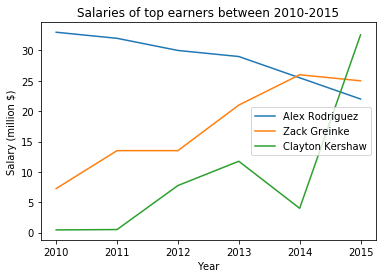

In [17]:
for player in players_of_interest:
    df = salary_df.loc[(salary_df['playerID'] == player) & (salary_df['yearID'] >= 2010)
                  & (salary_df['yearID'] <= 2015)]
    plt.plot(df['yearID'], df['salary (million)'], label= get_player_name(player))
    
plt.legend()
plt.title('Salaries of top earners between 2010-2015')
plt.xlabel('Year')
plt.ylabel('Salary (million $)')
plt.show()

The chart above tells us that the salary for Alex Rodriguez had been decreasing, and his pay was overtaken by Zack Greinke in 2014. Interestingly, Clayton Kershaw's pay shot up in 2015 to overtake them both.

Now, are we able to find out what are the positions for these top 3 players?

## Player Positions

Let's start by figuring out the main position for each player.

In [18]:
appearances_df = pd.read_csv('baseballdatabank-2017.1/core/Appearances.csv')
appearances_df.sample(2)

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
65332,1988,BOS,AL,benzito01,120,100.0,120,113,0,0,...,0,0,0,5,0,43,48,1.0,7.0,2.0
16092,1916,BRO,NL,coombja01,27,19.0,27,27,27,0,...,0,0,0,0,0,0,0,0.0,1.0,0.0


In [19]:
appearances_df.columns

Index(['yearID', 'teamID', 'lgID', 'playerID', 'G_all', 'GS', 'G_batting',
       'G_defense', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf',
       'G_cf', 'G_rf', 'G_of', 'G_dh', 'G_ph', 'G_pr'],
      dtype='object')

Let's drop columns not related to baseball player positions.

In [20]:
positions_df = appearances_df.drop(['yearID', 'teamID', 'lgID', 'G_all', 'GS', 'G_batting', 'G_defense', 'G_of'], axis=1)

In [21]:
positions_df.groupby('playerID').sum().head()

,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,G_ph,G_pr
playerID,,,,,,,,,,,,
aardsda01,331,0,0,0,0,0,0,0,0,0.0,0.0,0.0
aaronha01,0,0,210,43,7,0,315,308,2174,201.0,122.0,1.0
aaronto01,0,0,232,7,10,0,135,1,2,0.0,102.0,35.0
aasedo01,448,0,0,0,0,0,0,0,0,0.0,0.0,0.0
abadan01,0,0,8,0,0,0,0,0,1,0.0,7.0,1.0


In [22]:
# Find the main player position by seeing which column has the largest value for each player
df = positions_df.groupby('playerID').sum()
df['main position'] = df.idxmax(axis=1)
df.head()

,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,G_ph,G_pr,main position
playerID,,,,,,,,,,,,,
aardsda01,331,0,0,0,0,0,0,0,0,0.0,0.0,0.0,G_p
aaronha01,0,0,210,43,7,0,315,308,2174,201.0,122.0,1.0,G_rf
aaronto01,0,0,232,7,10,0,135,1,2,0.0,102.0,35.0,G_1b
aasedo01,448,0,0,0,0,0,0,0,0,0.0,0.0,0.0,G_p
abadan01,0,0,8,0,0,0,0,0,1,0.0,7.0,1.0,G_1b


In [23]:
# Translate the positions with a dict
position_dict = {'G_p':'pitcher',
                'G_c': 'catcher',
                'G_1b': '1st baseman',
                'G_2b': '2nd baseman',
                'G_3b': '3nd baseman',
                'G_ss': 'short stop',
                'G_lf': 'left fielder',
                'G_rf': 'right fielder',
                'G_cf': 'center fielder',
                'G_dh': 'designated hitter',
                'G_ph': 'pinch hitter',
                'G_pr': 'pinch runner',
                }

In [24]:
df.update(df['main position'].map(position_dict))
df.head()

,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,G_ph,G_pr,main position
playerID,,,,,,,,,,,,,
aardsda01,331,0,0,0,0,0,0,0,0,0.0,0.0,0.0,pitcher
aaronha01,0,0,210,43,7,0,315,308,2174,201.0,122.0,1.0,right fielder
aaronto01,0,0,232,7,10,0,135,1,2,0.0,102.0,35.0,1st baseman
aasedo01,448,0,0,0,0,0,0,0,0,0.0,0.0,0.0,pitcher
abadan01,0,0,8,0,0,0,0,0,1,0.0,7.0,1.0,1st baseman


Let's add in the player names.

In [25]:
#!!! should I just limit the appearances df to 1985 and beyond? 
#Since we want to cross reference with salary info, which starts from 1985.

In [26]:
df.reset_index(inplace=True)

In [27]:
df['name'] = df['playerID'].map(get_player_name)

TypeError encountered. ID is bolan01  , first name is  nan  last name is  Boland
TypeError encountered. ID is booth01  , first name is  nan  last name is  Booth
TypeError encountered. ID is carroch01  , first name is  nan  last name is  Carroll
TypeError encountered. ID is edwar01  , first name is  nan  last name is  Edwards
TypeError encountered. ID is evans01  , first name is  nan  last name is  Evans
TypeError encountered. ID is frank01  , first name is  nan  last name is  Franklin
TypeError encountered. ID is gaver01  , first name is  nan  last name is  Gavern
TypeError encountered. ID is harribe01  , first name is  nan  last name is  Harrison
TypeError encountered. ID is helli01  , first name is  nan  last name is  Hellings
TypeError encountered. ID is higby01  , first name is  nan  last name is  Higby
TypeError encountered. ID is hilde01  , first name is  nan  last name is  Hillebrand
TypeError encountered. ID is jones02  , first name is  nan  last name is  Jones
TypeError encoun

It seems there are some players with missing name information, let's check out a few and see if we should drop them.

In [28]:
appearances_df[appearances_df['playerID'] == 'booth01']

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
541,1875,NH1,NaN,booth01,1,NaN,1,1,0,0,...,0,0,1,0,0,0,0,NaN,NaN,NaN


In [29]:
appearances_df[appearances_df['playerID'] == 'hilde01']

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
8686,1902,CHN,NL,hilde01,1,NaN,1,1,0,0,...,0,0,0,0,0,1,1,NaN,NaN,NaN


In [30]:
appearances_df[appearances_df['playerID'] == 'wills01']

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
2730,1884,KCU,UA,wills01,5,NaN,5,5,0,0,...,0,0,0,0,5,0,5,NaN,NaN,NaN
2731,1884,WS7,AA,wills01,4,NaN,4,4,0,0,...,0,0,0,1,3,0,4,NaN,NaN,NaN


Seems like those players are from very early years, in the late 1800s and early 1900s. Since we're interested in the salary information that only starts from 1985, we're safe to drop these players from our table.

In [31]:
df.loc[df['playerID'] == 'wills01']

,playerID,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,G_ph,G_pr,main position,name
18378,wills01,0,0,0,0,0,0,1,8,0,NaN,NaN,NaN,center fielder,N/A


In [32]:
df.replace('N/A', np.nan, inplace=True)
df.dropna(subset=['name'], inplace=True)

In [33]:
df.set_index('playerID', inplace=True)
df.head()

,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,G_ph,G_pr,main position,name
playerID,,,,,,,,,,,,,,
aardsda01,331,0,0,0,0,0,0,0,0,0.0,0.0,0.0,pitcher,David Aardsma
aaronha01,0,0,210,43,7,0,315,308,2174,201.0,122.0,1.0,right fielder,Hank Aaron
aaronto01,0,0,232,7,10,0,135,1,2,0.0,102.0,35.0,1st baseman,Tommie Aaron
aasedo01,448,0,0,0,0,0,0,0,0,0.0,0.0,0.0,pitcher,Don Aase
abadan01,0,0,8,0,0,0,0,0,1,0.0,7.0,1.0,1st baseman,Andy Abad


Now we can find out the positions of the top earners between 2010-2015.

In [34]:
df.loc[players_of_interest]

,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,G_ph,G_pr,main position,name
playerID,,,,,,,,,,,,,,
rodrial01,0,0,2,0,1194,1272,0,0,0,298.0,38.0,4.0,short stop,Alex Rodriguez
greinza01,390,0,0,0,0,0,0,0,0,0.0,4.0,2.0,pitcher,Zack Greinke
kershcl01,265,0,0,0,0,0,0,0,0,0.0,4.0,2.0,pitcher,Clayton Kershaw


2 out of the 3 players we were interested in were pitchers.

Now, let's explore if there's a connection between player positions and the salaries they earn.

In [35]:
#!!! needs more thought on how to group. By player, year?  
#!!! Salaries should be plotted out per year? Or average over the players' careers?

In [36]:
#layer_salary_df = salary_df.groupby('playerID').set_index('playerID')

In [37]:
salary_df.groupby('playerID').head()

,yearID,teamID,lgID,playerID,salary,salary (million)
0,1985,ATL,NL,barkele01,870000,0.870000
1,1985,ATL,NL,bedrost01,550000,0.550000
2,1985,ATL,NL,benedbr01,545000,0.545000
3,1985,ATL,NL,campri01,633333,0.633333
4,1985,ATL,NL,ceronri01,625000,0.625000
5,1985,ATL,NL,chambch01,800000,0.800000
6,1985,ATL,NL,dedmoje01,150000,0.150000
7,1985,ATL,NL,forstte01,483333,0.483333
8,1985,ATL,NL,garbege01,772000,0.772000
9,1985,ATL,NL,harpete01,250000,0.250000
